# Table of contents
* [Word Tokenization](#word-tokenization)
    * [Most Common Words](#most-common-words)
    * [Feature Creation](#most-common-words-feature-creation)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# Import the tweets dataset, this is a cut down version of the full tweet 
# dataset per the operations performed in the file "eda-rea-v-liv-2018"
en_tweets_df = pd.read_csv('en_tweets_df.csv', lineterminator='\n')

In [3]:
# As this dataset is generated from earlier work it carries its prior index, the below changes the column name
en_tweets_df.rename(columns={'Unnamed: 0':'original_df_index'}, inplace=True)

In [2]:
# Import NLTK libraries
import nltk
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from sklearn import preprocessing

import re

[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Word Tokenization <a class="anchor" id="word-tokenization"></a>

In [34]:
# Create a function that returns tokenizes, cleans and stems words for a tweet
english_stopwords = stopwords.words('english')

# Context specific stop words (refer "most common words" section below for identification approach
# rt = short for retweet, this does not provide any insights and a column already exists to identify retweets
# http & https = the start of web links these provide little value as "words", future work: these could be
# to build a feature along thelines of "Contains Web Link?"
# uclfinal, championsleague, championsleaguefinal = "hashtag"/topical words, given the original tweet dataset
# contained only tweets that had a hashtag of uclfinal these words do not add value to the analysis
custom_stopwords = ['rt', 'http', 'https', 'uclfinal', 'championsleague', 'championsleaguefinal', 'lfcrma',  
                    'liverpoolvsrealmadrid', 'livrma', 'realiv', 'realliverpool', 'realmadridliverpool', 'realmadridvsliverpool', 
                    'rmalfc', 'rmaliv', 'rmavlfc', 'rmavliv', 'rmavsliv', 'rmliv', 'rmvsliv', 'retweet', 'retweeted']

ps = PorterStemmer()

# Combine the two stop words lists
stop_words = english_stopwords + custom_stopwords

def TokenizeTweet(tweet):
    word_tokenized = word_tokenize(tweet)

    
    cleaned_words_tokenized = [word.lower().strip() for word in word_tokenized] # lowercasing
    
    cleaned_words_tokenized = [re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', word) for word in cleaned_words_tokenized] # remove URLs
    cleaned_words_tokenized = [re.sub('@[^\s]+', 'AT_USER', word) for word in cleaned_words_tokenized] # remove usernames
    cleaned_words_tokenized = [re.sub(r'#([^\s]+)', r'\1', word) for word in cleaned_words_tokenized] # remove the # in #hashtag   
    cleaned_words_tokenized = [word.replace('(','').replace(')','') for word in cleaned_words_tokenized if word.isalpha()]  # replacing some unwanted things
    
    # Ideally all checks could be moved into this single for loop, rather than iterating words multiple times.
    for n, i in enumerate(cleaned_words_tokenized):
        if i in ['liverpool', 'lfc', 'ufcliverpool', 'liv']:
            cleaned_words_tokenized[n] = 'liverpoolfc'
            
        if i in ['rma', 'madrid']:
            cleaned_words_tokenized[n] = 'realmadrid'
    
    cleaned_words_tokenized = [word for word in cleaned_words_tokenized if word not in stop_words] # removing stopwords
    cleaned_words_tokenized = [ps.stem(word) for word in cleaned_words_tokenized] # stemming
    
    return cleaned_words_tokenized

In [35]:
# Tokenize words in tweets
en_tweets_df['tokenized_words'] = en_tweets_df.apply(lambda row: TokenizeTweet(row['tweet_text']), axis=1)

### Most Common Words <a class="anchor" id="most-common-words"></a>

In [43]:
# There are three key benefits to finding the most common words:
    # 1. Further refinements could be made to TokenizedWords in terms of words to exclude
    # 2. We can obtain further insights into the data
    # 3. Can select key words that could be used to generate features    

# Convert tokenized words column into a single list of words
words_list = en_tweets_df['tokenized_words'].values.tolist()

# Flatten the list
flattened_words_list = [j for sub in words_list for j in sub]

# Find the most common words
fdist = FreqDist(x.lower() for x in flattened_words_list)
fdist.most_common(25)

[('liverpoolfc', 48196),
 ('salah', 37548),
 ('ramo', 31736),
 ('realmadrid', 28476),
 ('bale', 22325),
 ('goal', 21128),
 ('real', 20624),
 ('sergio', 14425),
 ('gareth', 11275),
 ('final', 10888),
 ('world', 8579),
 ('mo', 8537),
 ('kariu', 8418),
 ('one', 7910),
 ('ronaldo', 7447),
 ('cup', 7347),
 ('time', 7302),
 ('shoulder', 7209),
 ('game', 7119),
 ('like', 7022),
 ('win', 6609),
 ('score', 6590),
 ('ever', 6378),
 ('watch', 6345),
 ('come', 6275)]

### Feature Creation  <a class="anchor" id="most-common-words-feature-creation"></a>

In [39]:
import math
number_of_documents = en_tweets_df.shape[0]

def NumberOfDocumentsContainingWord(word):
    return en_tweets_df[pd.DataFrame(en_tweets_df.tokenized_words.tolist()).isin([word]).any(1)].shape[0]

# tfi,j  = number of occurence of term i in document j
# N  = number of documents in the corpus
# dfi  = number of documents with term i
def CalculateTFIDF(tfij, N, dfi):
    return tfij * math.log((N/dfi))

def FeatureCreation(word, count, iteration):
    N = number_of_documents
    dfi = NumberOfDocumentsContainingWord(word)
    
    en_tweets_df['FT_' + word + '_frequency'] = en_tweets_df.apply(lambda row: CalculateTFIDF(row['tokenized_words'].count(word), N, dfi), axis=1)
    print(f'{iteration}. Feature created for {word}')
    

In [44]:
# Create TFIDF for 5000 words
i = 1
for word, count in fdist.most_common(5000):
    FeatureCreation(word, count, i)
    i += 1

1. Feature created for liverpoolfc
2. Feature created for salah
3. Feature created for ramo
4. Feature created for realmadrid
5. Feature created for bale
6. Feature created for goal
7. Feature created for real
8. Feature created for sergio
9. Feature created for gareth
10. Feature created for final
11. Feature created for world
12. Feature created for mo
13. Feature created for kariu
14. Feature created for one
15. Feature created for ronaldo
16. Feature created for cup
17. Feature created for time
18. Feature created for shoulder
19. Feature created for game
20. Feature created for like
21. Feature created for win
22. Feature created for score
23. Feature created for ever
24. Feature created for watch
25. Feature created for come
26. Feature created for see
27. Feature created for get
28. Feature created for champion
29. Feature created for go
30. Feature created for fan
31. Feature created for leagu
32. Feature created for best
33. Feature created for injur
34. Feature created for te

KeyboardInterrupt: 

In [3]:
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

###############################################################################################
###############################################################################################
# Given the length fo time feature creation takes, need a mechanism to persist results

h5File = "en_tweets_df_TFIDF.h5"; # Name h5File

#en_tweets_df.to_hdf(h5File, "/data/"); # Export file 

In [6]:
###############################################################################################
###############################################################################################
# Use pandas again to read data from the hdf5 file to the pandas DataFrame
en_tweets_df = pd.read_hdf(h5File, "/data/");
en_tweets_df.head()

,original_df_index,id,text,lang,retweeted_status,created_at,user,tweet_text,is_retweet,created_at_hour_minute,...,FT_offic_frequency,FT_number_frequency,FT_pick_frequency,FT_total_frequency,FT_doubt_frequency,FT_retain_frequency,FT_gabryboschetto_frequency,FT_nois_frequency,FT_impress_frequency,y
0,0,1.000366e+18,MATCH-DAY\n\nReal Madrid vs Liverpool\n\n#UCLF...,en,NaN,2018-05-26 13:18:30+00:00,"{'id': 2846595478, 'id_str': '2846595478', 'na...",MATCH-DAY\n\nReal Madrid vs Liverpool\n\n#UCLF...,False,2018-05-26 13:18:00+00:00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,4,1.000366e+18,RT @ECG_Unofficial: We will like to categorica...,en,{'created_at': 'Sat May 26 11:14:44 +0000 2018...,2018-05-26 13:18:31+00:00,"{'id': 902735000445095938, 'id_str': '90273500...",RT @ECG_Unofficial: We will like to categorica...,True,2018-05-26 13:18:00+00:00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,5,1.000366e+18,Real Madrid.... LETS GO!!!!!!!!!!!!!!!!!!!!!!!...,en,NaN,2018-05-26 13:18:31+00:00,"{'id': 240672622, 'id_str': '240672622', 'name...",Real Madrid.... LETS GO!!!!!!!!!!!!!!!!!!!!!!!...,False,2018-05-26 13:18:00+00:00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,7,1.000366e+18,RT @YNWA_Claire: Please? 🙏🏼\n\n#UCLFinal https...,en,{'created_at': 'Sat May 26 13:13:45 +0000 2018...,2018-05-26 13:18:31+00:00,"{'id': 277019564, 'id_str': '277019564', 'name...",RT @YNWA_Claire: Please? 🙏🏼\n\n#UCLFinal https...,True,2018-05-26 13:18:00+00:00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,8,1.000366e+18,RT @ChampionsLeague: Two European giants go he...,en,{'created_at': 'Sat May 26 13:00:01 +0000 2018...,2018-05-26 13:18:31+00:00,"{'id': 957644286350315521, 'id_str': '95764428...",RT @ChampionsLeague: Two European giants go he...,True,2018-05-26 13:18:00+00:00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [7]:
en_tweets_df_text_only = en_tweets_df[['id','tweet_text', 'tokenized_words']]
en_tweets_df_text_only.sample(5)

,id,tweet_text,tokenized_words
48270,1.000457e+18,"And now it's Carvajal, 😢😢\nWhy God why... #UCL...","[carvaj, god]"
180434,1.000477e+18,RT @ChampionsLeague: ⏰FULL TIME! ⏰\nReal Madri...,"[time, real, realmadrid, make, three, ucl, tit..."
86128,1.000463e+18,@AlexiLalas are ya sure? https://t.co/MVOR23rwiv,"[alexilala, ya, sure]"
175903,1.000476e+18,RT @iAmAClipse: Here for this... https://t.co/...,[iamaclips]
80848,1.000462e+18,@SimpsonsQOTD Posted... \nhttps://t.co/vsrKt1PSmp,"[simpsonsqotd, post]"


In [ ]:
en_tweets_df['flatten_tokenized_words'] = en_tweets_df.apply(lambda row: ' '.join(row['tokenized_words']), axis=1)

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
v = TfidfVectorizer()
x = v.fit_transform(en_tweets_df['flatten_tokenized_words'])

MemoryError: Unable to allocate 36.0 GiB for an array with shape (188087, 25654) and data type float64

In [13]:
###############################################################################################
###############################################################################################

# FEATURE CREATION FOR WORD FREQUENCY ONLY
# The following functions are used to create a feature column for the most common words
# def WordFrequency(tokenized_words, word):
#     return tokenized_words.count(word)
    

# def FeatureCreation(list_of_words):
#     i = 1
#     for word in list_of_words:
#         en_tweets_df['FT_' + word + '_frequency'] = en_tweets_df.apply(lambda row: WordFrequency(row['tokenized_words'], word), axis=1)
#         print(f'{i}. Feature created for {word}')
#         i += 1
        
# # Create features 
# FeatureCreation([i[0] for i in fdist.most_common(250)])

###############################################################################################
###############################################################################################

In [45]:
# Define a list of feature columns, output length of list
cols = [col for col in en_tweets_df.columns if col[:3] == 'FT_']
len(cols)

772

In [16]:
# If tweets do not contain any of the most common words then there are no insights into the topic
# the below is used to drop such cases
en_tweets_df['sum_of_FT_cols'] = en_tweets_df[cols].sum(axis=1)
en_tweets_df_with_features = en_tweets_df[en_tweets_df['sum_of_FT_cols'] != 0]
print(f'Original dataframe shape: {en_tweets_df.shape}')
print(f'With features dataframe shape: {en_tweets_df_with_features.shape}')

Original dataframe shape: (188087, 262)
With features dataframe shape: (178631, 262)


### Models <a class="anchor" id="most-common-words-models"></a>

#### KMeans <a class="anchor" id="most-common-words-kmeans"></a>

In [49]:
import sklearn
import sklearn.metrics as sm
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn import datasets
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA

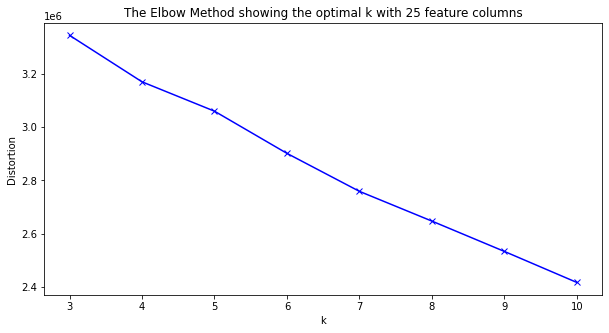

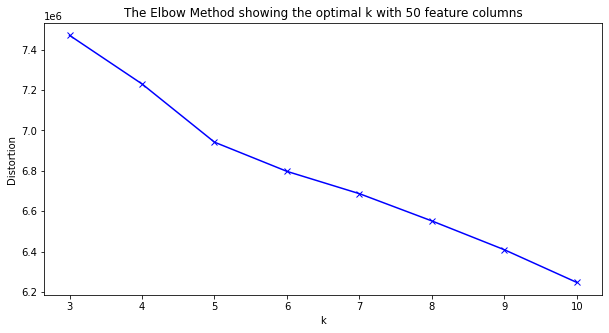

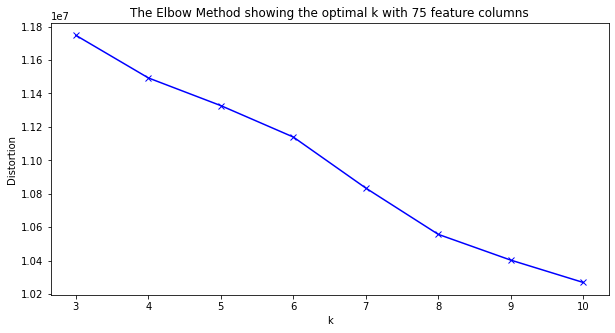

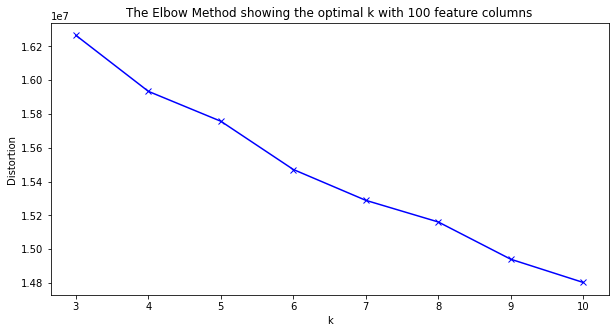

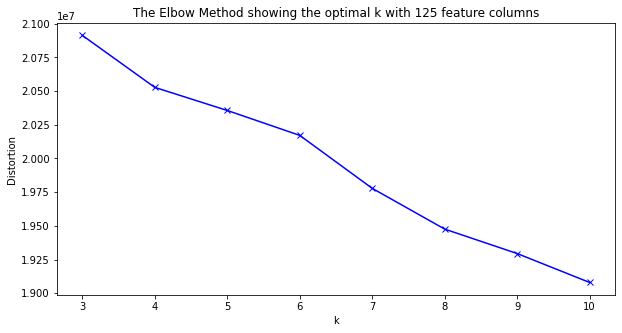

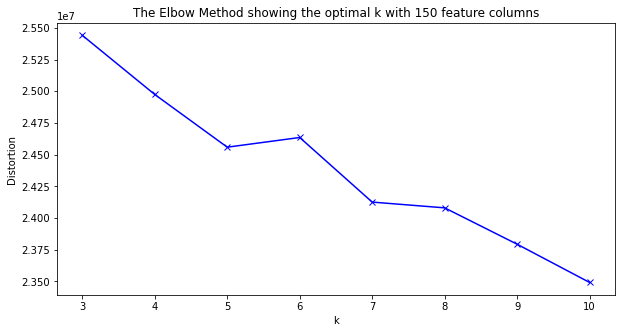

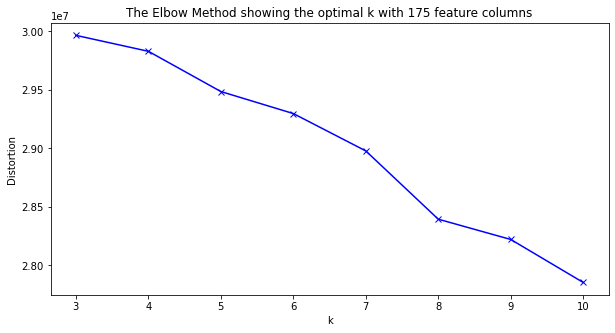

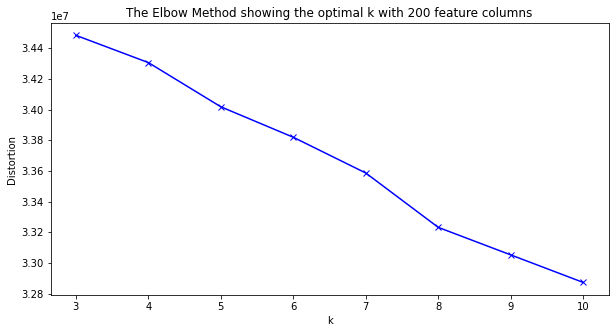

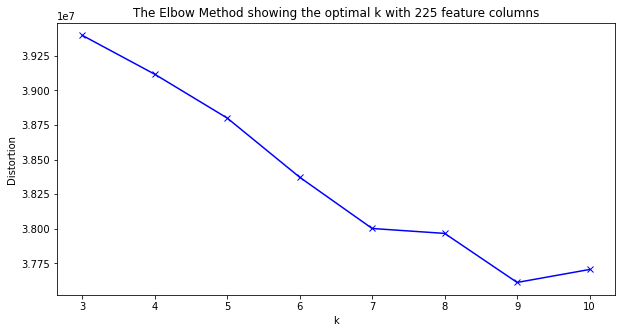

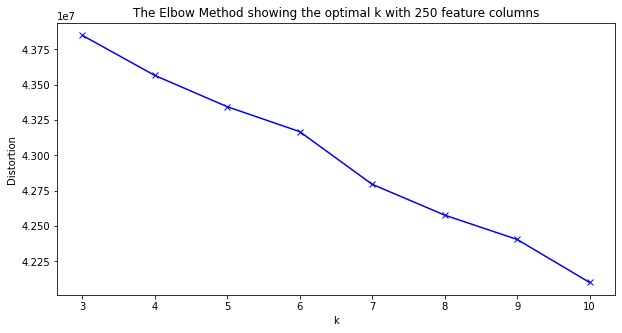

In [18]:
# Identify the optimal number of clusters (k), also considering the number of feature columns. This should assist in review of the cluster samples output.
pd.options.mode.chained_assignment = None  # default='warn'
K = range(3, 11)
for num_of_FT_cols in range(25, 251, 25):
    distortions = []
    for k in K:
        # Create X ensuring only records that have at least one of the features are included
        X = en_tweets_df_with_features[cols[:num_of_FT_cols]]
        X['sum_of_FT_cols'] = X.sum(axis=1)
        X = X[cols[:num_of_FT_cols]][X['sum_of_FT_cols'] != 0]

        X_scaled = preprocessing.scale(X)

        # Fit and predict model
        kmeans = KMeans(n_clusters=k, random_state=8)
        kmeans.fit(X_scaled)
        distortions.append(kmeans.inertia_)
        
    plt.figure(figsize=(10, 5))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title(f'The Elbow Method showing the optimal k with {num_of_FT_cols} feature columns')
    plt.show()

In [50]:
# Based on the above diagrams 7 clusters with 225 looks like it could hold some insights
# Create X ensuring only records that have at least one of the features are included
k = 6
X = en_tweets_df[cols]
# X['sum_of_FT_cols'] = X.sum(axis=1)
# X = X[cols][X['sum_of_FT_cols'] != 0]

# Fit and predict model
kmeans = KMeans(n_clusters=k, random_state=8)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

In [53]:
# Print a number of tweets for each cluster
y = pd.Series(y_kmeans)
df_tweet_y = pd.DataFrame(en_tweets_df)
df_tweet_y['y'] = pd.Series(y)

pd.set_option('display.max_colwidth', None)

print(f'------------------------------------------------------------------------')
print(f'------------------------------------------------------------------------')
# print(f'k = {k} ---- Number of FT cols = {num_of_FT_cols}')
print(f'Data shape = {X.shape}')

for i in range(0, k):
    print(f'****************************************** \n Cluster {i}')
    print('******************************************')
    print(df_tweet_y['tweet_text'][(df_tweet_y['y'] == i)].sample(15).to_string())
    print('****************************************** \n')

print(f'------------------------------------------------------------------------')
print(f'------------------------------------------------------------------------\n\n\n')

------------------------------------------------------------------------
------------------------------------------------------------------------
Data shape = (188087, 772)
****************************************** 
 Cluster 0
******************************************
156428                          RT @itsnotJesusXO: Fuck football. Fuck this game. Fuck Real Madrid. Fuck their referees. Fuck UEFA. https://t.co/naqHnqpS7U
82900         RT @TOKOYVMI: FUCK RAMOS FUCK RAMOS FUCK RAMOS FUCK RAMOS FUCK RAMOS FUCK RAMOS FUCK RAMOS FUCK RAMOS FUCK RAMOS FUCK RAMOS\nFUCK RAMOS FUCK…
54364         RT @TOKOYVMI: FUCK RAMOS FUCK RAMOS FUCK RAMOS FUCK RAMOS FUCK RAMOS FUCK RAMOS FUCK RAMOS FUCK RAMOS FUCK RAMOS FUCK RAMOS\nFUCK RAMOS FUCK…
73296         RT @Samuel14122417: FUCK RAMOS FUCK RAMOS FUCK RAMOS FUCK RAMOS FUCK RAMOS FUCK RAMOS FUCK RAMOS FUCK RAMOS FUCK RAMOS FUCK RAMOS\nFUCK RAMO…
52887     RT @JrMoe_: FUCK YOU, SERGIO RAMOS\nFUCK YOU, SERGIO RAMOS\nFUCK YOU, SERGIO RAMOS\nFUCK YOU, S

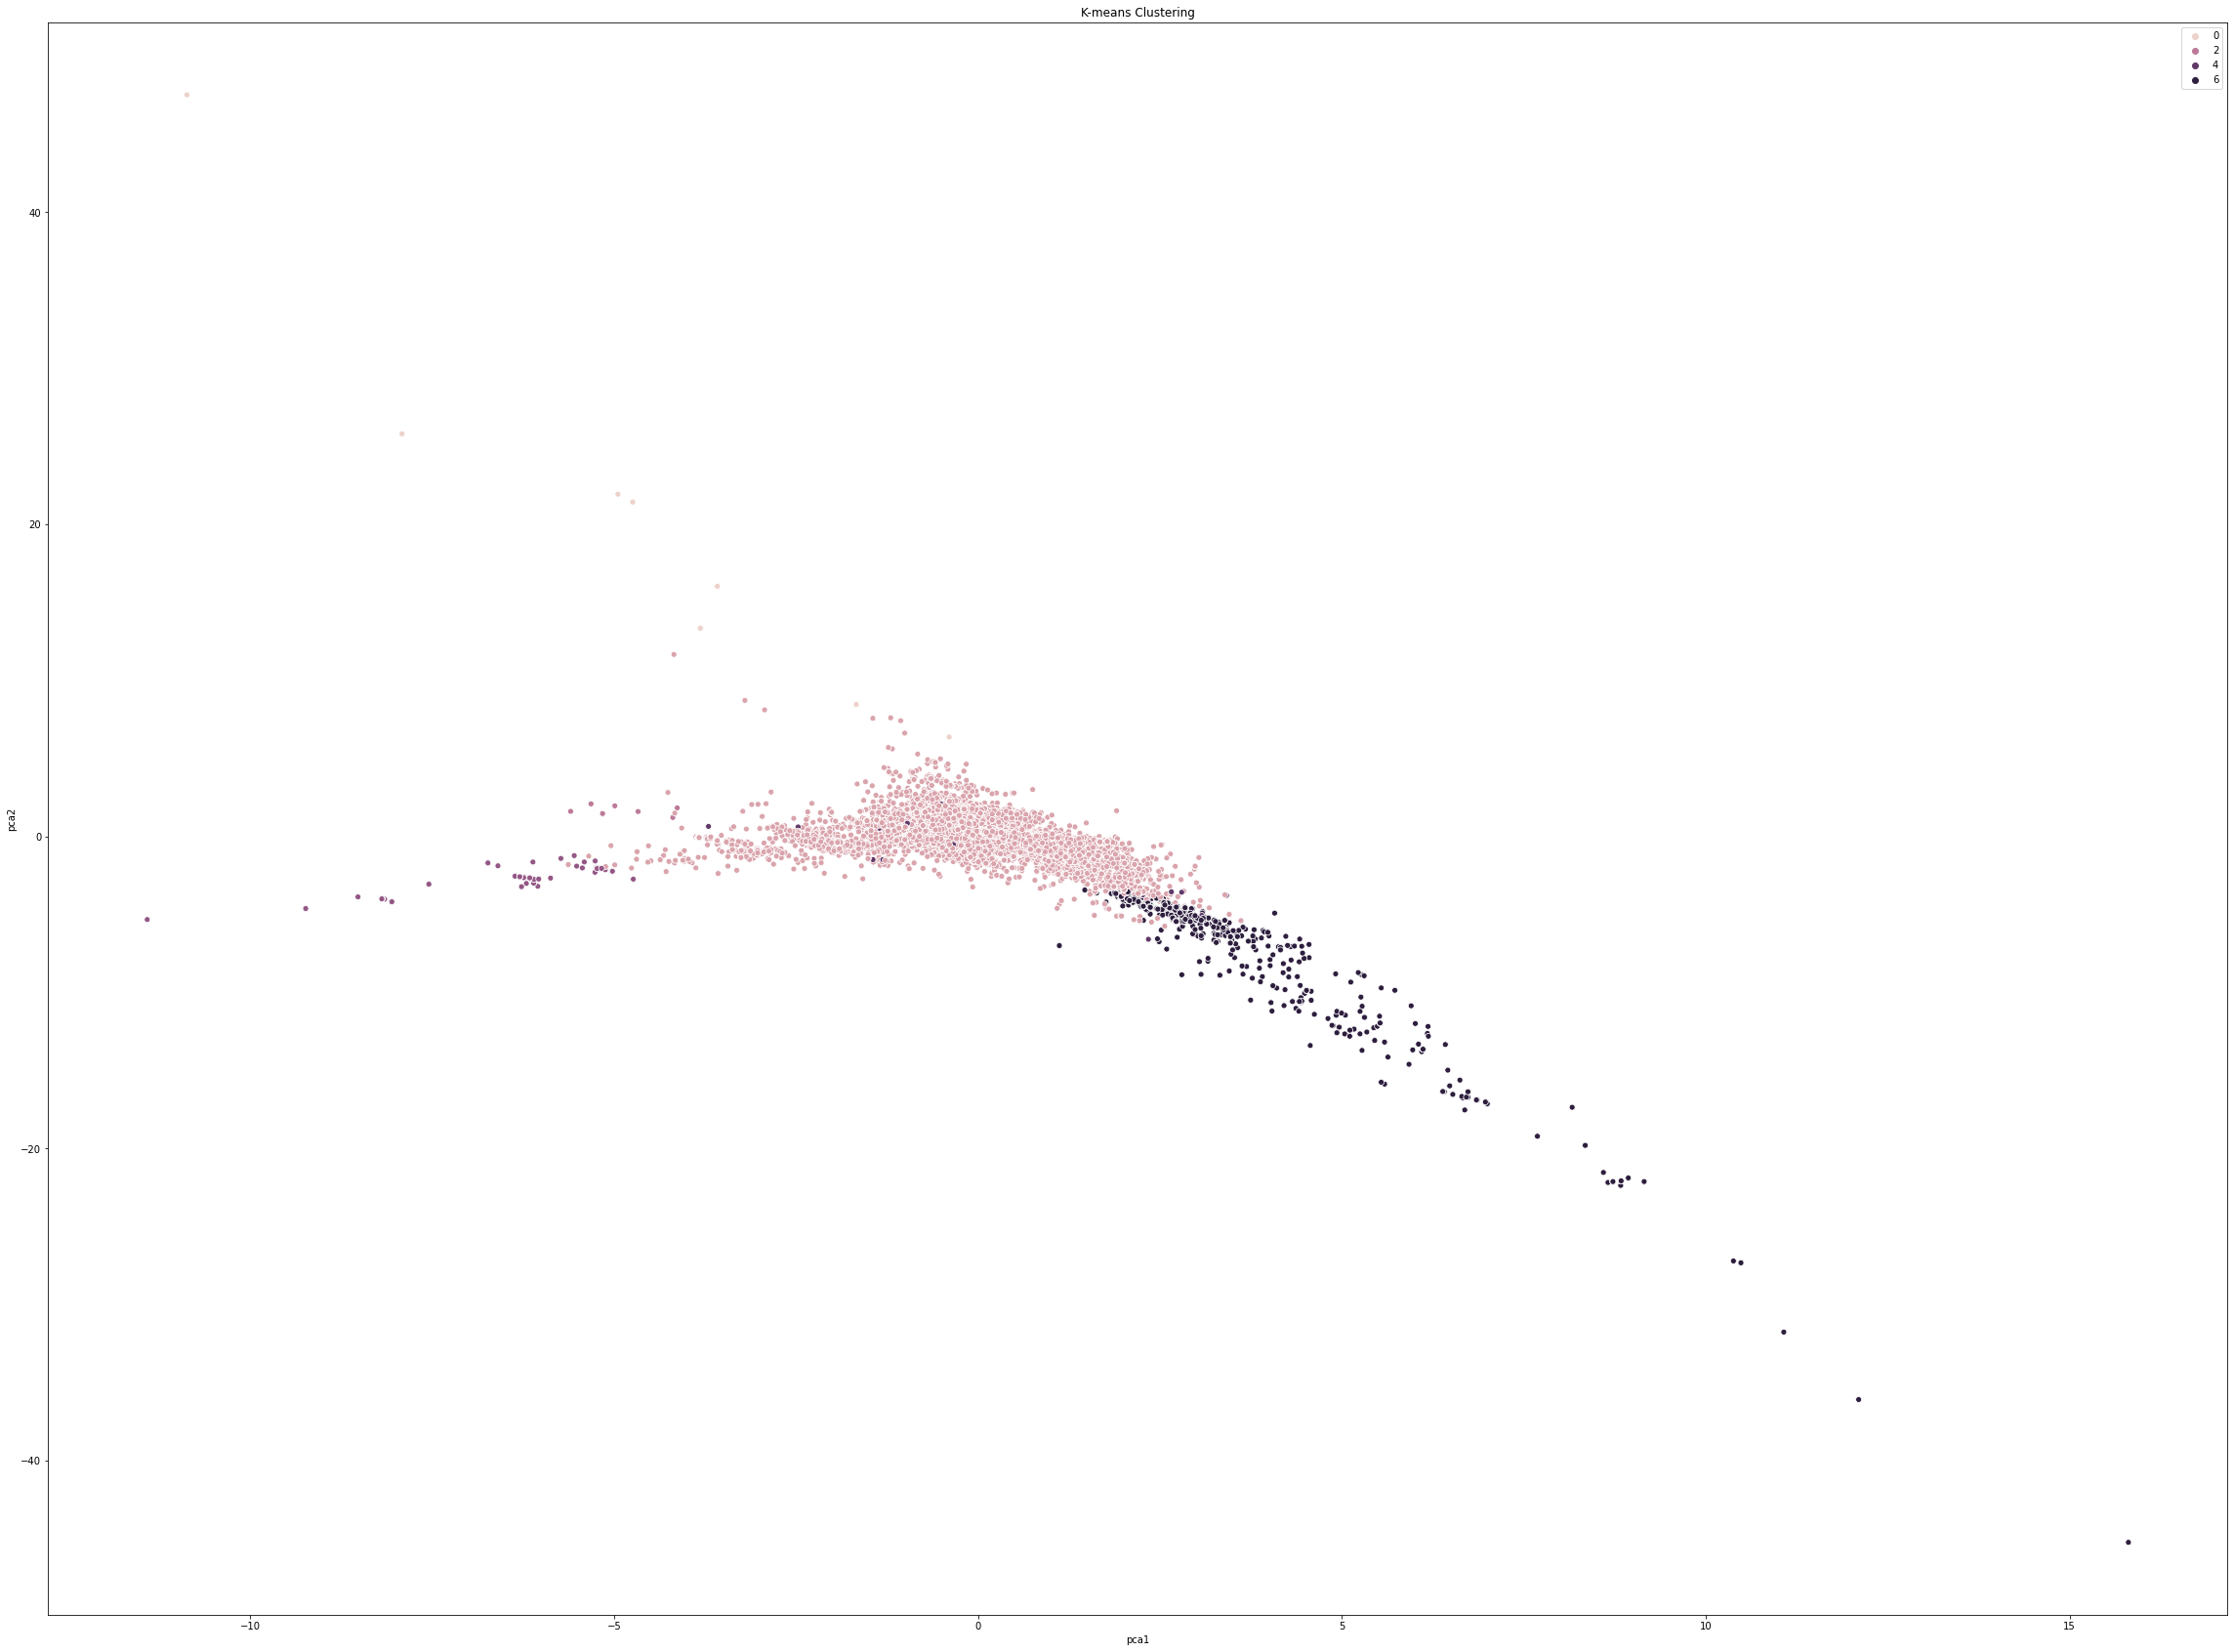

In [54]:
### Run PCA on the data and reduce the dimensions in pca_num_components dimensions
reduced_data = PCA(n_components=2).fit_transform(X)
results = pd.DataFrame(reduced_data,columns=['pca1','pca2'])

plt.figure(figsize=(40,30))
sns.scatterplot(x="pca1", y="pca2", hue=y_kmeans, data=results)
plt.title('K-means Clustering')
plt.show()

In [ ]:
# Return 3 - 10 clusters for cummulative sets of 25 columns, the first 25 are the most common words
for k in range(3, 11):
    for num_of_FT_cols in range(25, 501, 25):
        # Create X ensuring only records that have at least one of the features are included
        X = en_tweets_df_with_features[cols[:num_of_FT_cols]]
        X['sum_of_FT_cols'] = X.sum(axis=1)
        X = X[cols[:num_of_FT_cols]][X['sum_of_FT_cols'] != 0]

        # Fit and predict model
        kmeans = KMeans(n_clusters=k, random_state=8)
        kmeans.fit(X)
        y_kmeans = kmeans.predict(X)
        
        # Print a number of tweets for each cluster
        y = pd.Series(y_kmeans)
        df_tweet_y = pd.DataFrame(en_tweets_df_with_features)
        df_tweet_y['y'] = pd.Series(y)

        pd.set_option('display.max_colwidth', None)
        
        print(f'------------------------------------------------------------------------')
        print(f'------------------------------------------------------------------------')
        print(f'k = {k} ---- Number of FT cols = {num_of_FT_cols}')
        print(f'Data shape = {X.shape}')

        for i in range(0, k):
            print(f'****************************************** \n Cluster {i}')
            print('******************************************')
            print(df_tweet_y['tweet_text'][(df_tweet_y['y'] == i) & (df_tweet_y['is_retweet'] == False)].sample(5).to_string())
            print('****************************************** \n')
            
        print(f'------------------------------------------------------------------------')
        print(f'------------------------------------------------------------------------\n\n\n')

# ------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------
# Useful snippets etc.

In [ ]:
###############################################################
# Memory usage https://stackoverflow.com/questions/16261240/releasing-memory-of-huge-numpy-array-in-ipython/16278056
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))